In [4]:
pip install tensorflow keras numpy matplotlib opencv-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Noisy Images Shape: (300, 256, 256, 3)
Ground Truth Images Shape: (300, 256, 256, 3)


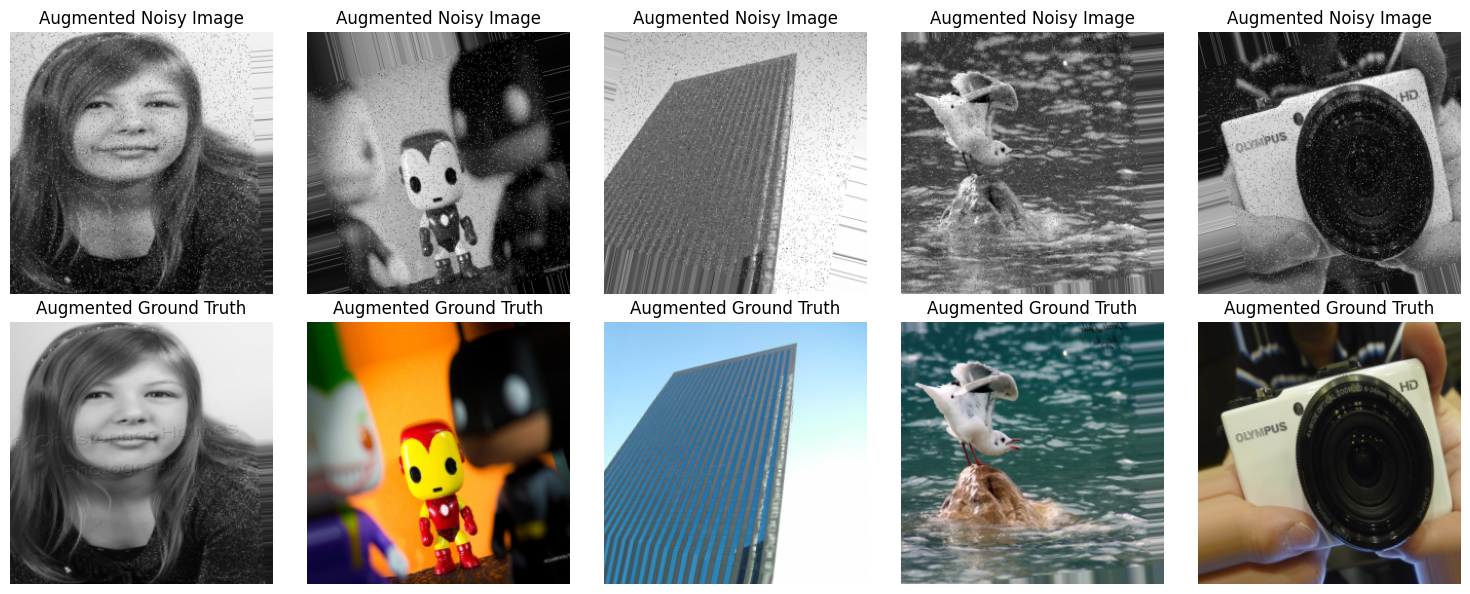

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load images from a directory
def load_images_from_directory(directory, target_size=(256, 256)):
    images = []
    for filename in sorted(os.listdir(directory)):  # Sort to ensure matching order
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            img = cv2.imread(filepath)  # Read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize to target size
            images.append(img)
    return np.array(images)


# Directories for noisy and ground truth images
noisy_dir = "C:\\Users\\nandh\\Desktop\\project files\\SALT AND PEPPER\\Noisy_folder"
ground_truth_dir = "C:\\Users\\nandh\\Desktop\\project files\\SALT AND PEPPER\\Ground_truth"

# Load images
target_size = (256, 256)  # Resize all images to 128x128
noisy_images = load_images_from_directory(noisy_dir, target_size=target_size)
ground_truth_images = load_images_from_directory(ground_truth_dir, target_size=target_size)

# Normalize images to [0, 1]
noisy_images = noisy_images / 255.0
ground_truth_images = ground_truth_images / 255.0

# Print shapes for confirmation
print(f"Noisy Images Shape: {noisy_images.shape}")
print(f"Ground Truth Images Shape: {ground_truth_images.shape}")

# Data augmentation for noisy images
data_gen_args = dict(
    rotation_range=15,         # Random rotation in degrees
    width_shift_range=0.1,     # Horizontal shift
    height_shift_range=0.1,    # Vertical shift
    shear_range=0.1,           # Shearing transformation
    zoom_range=0.1,            # Zoom in/out
    horizontal_flip=True,      # Random horizontal flips
    fill_mode='nearest'        # Filling pixels outside boundaries
)

noisy_datagen = ImageDataGenerator(**data_gen_args)
ground_truth_datagen = ImageDataGenerator(**data_gen_args)

# Fit the data generator to the images
noisy_datagen.fit(noisy_images)
ground_truth_datagen.fit(ground_truth_images)

# Create augmented image generators
noisy_generator = noisy_datagen.flow(noisy_images, batch_size=8, seed=42)
ground_truth_generator = ground_truth_datagen.flow(ground_truth_images, batch_size=8, seed=42)

# Combine the generators
def combined_generator(noisy_gen, ground_truth_gen):
    for noisy_batch, ground_truth_batch in zip(noisy_gen, ground_truth_gen):
        yield noisy_batch, ground_truth_batch

train_generator = combined_generator(noisy_generator, ground_truth_generator)

# Visualize augmented images
def visualize_augmented_samples(generator, num_samples=5):
    augmented_noisy, augmented_ground = next(generator)
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        # Augmented noisy image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(augmented_noisy[i])
        plt.title("Augmented Noisy Image")
        plt.axis('off')
        
        # Augmented ground truth image
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(augmented_ground[i])
        plt.title("Augmented Ground Truth")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize 5 augmented samples
visualize_augmented_samples(train_generator, num_samples=5)


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define the deeper U-Net model
def a_build_deeper_unet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Additional layers for more depth
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs, outputs)

# Build and compile the U-Net model
input_size = (256, 256, 3)  # Set input size
model = a_build_deeper_unet(input_size)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Reduced learning rate
              loss='mse',  # Mean Squared Error loss
              metrics=['mae'])  # Mean Absolute Error as a metric

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ up_sampling2d_4[

 Total params: 31,379,075 (119.70 MB)

 Trainable params: 31,379,075 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_noisy, val_noisy, train_ground, val_ground = train_test_split(
    noisy_images, ground_truth_images, test_size=0.2, random_state=42
)

# Create TensorFlow datasets
def create_dataset(noisy, ground, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((noisy, ground))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Batch size
batch_size = 16

# Train and validation datasets
train_dataset = create_dataset(train_noisy, train_ground, batch_size=batch_size)
val_dataset = create_dataset(val_noisy, val_ground, batch_size=batch_size, shuffle=False)

# Print dataset details
print(f"Train Dataset: {len(train_noisy)} samples, Batch Size: {batch_size}")
print(f"Validation Dataset: {len(val_noisy)} samples, Batch Size: {batch_size}")

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150
)


Train Dataset: 240 samples, Batch Size: 16
Validation Dataset: 60 samples, Batch Size: 16
Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - loss: 0.0745 - mae: 0.2314 - val_loss: 0.0726 - val_mae: 0.2353
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - loss: 0.0574 - mae: 0.2011 - val_loss: 0.0360 - val_mae: 0.1553
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - loss: 0.0306 - mae: 0.1377 - val_loss: 0.0238 - val_mae: 0.1165
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - loss: 0.0244 - mae: 0.1180 - val_loss: 0.0279 - val_mae: 0.1255
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 8s/step - loss: 0.0207 - mae: 0.1083 - val_loss: 0.0194 - val_mae: 0.1046
Epoch 6/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 116s 8s/step - loss: 0.0173 - mae: 0.0971 - val_loss: 0.0170 - val_mae: 0.0945
Epoch 7/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 119s 8s/step - loss: 0.0179 - mae: 0.0966 - val_loss: 0.0177 - val_mae: 0.0974
Epoch 8/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 8s/step - loss: 0.0174 - mae: 0.0963 - v

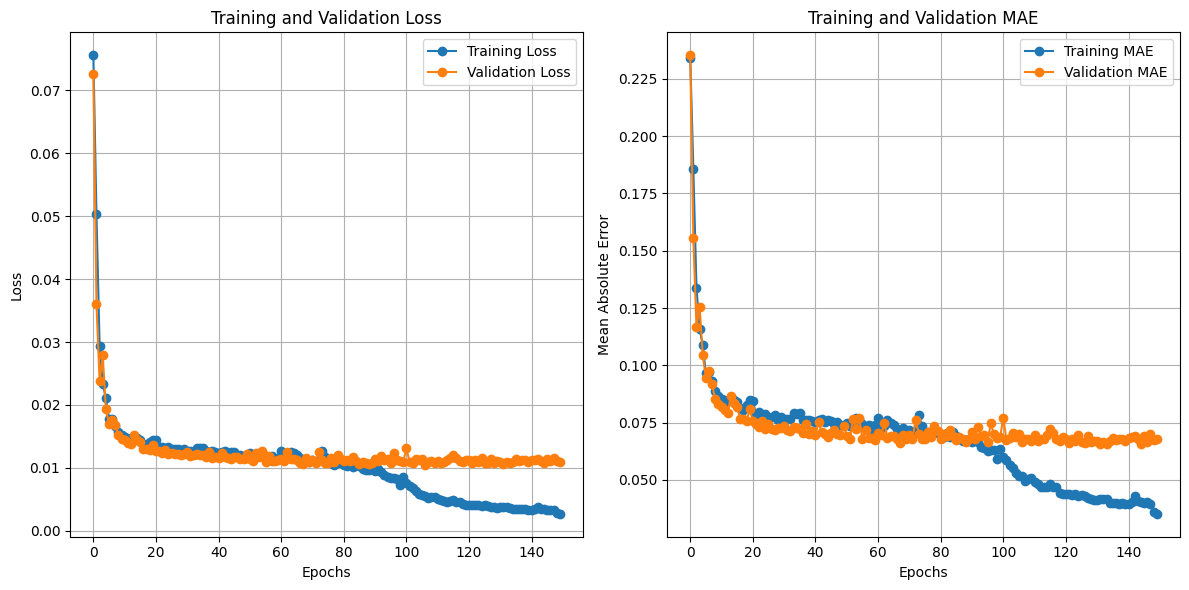

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', marker='o')
    plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


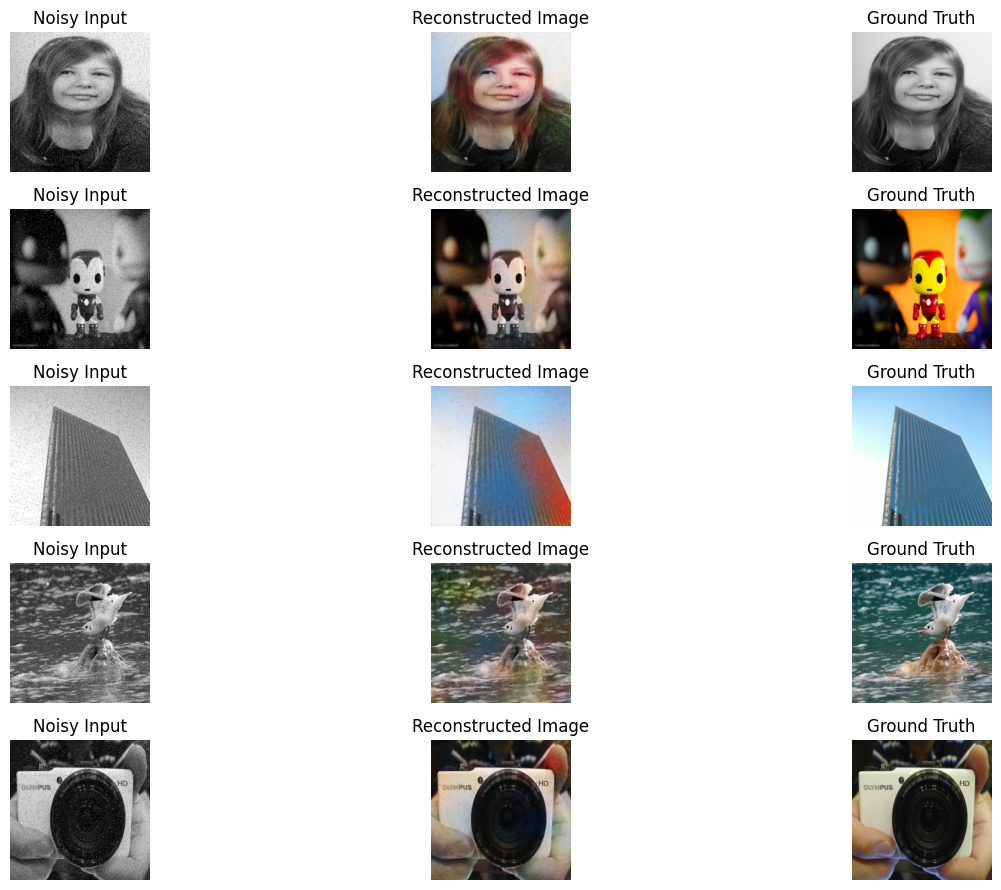

In [12]:
def visualize_predictions(model, noisy_images, ground_truth_images, num_samples=5):
    # Get predictions
    predictions = model.predict(noisy_images[:num_samples])

    plt.figure(figsize=(15, 9))
    for i in range(num_samples):
        # Noisy image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(noisy_images[i])
        plt.title("Noisy Input")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(np.clip(predictions[i], 0, 1))  # Clip to valid range
        plt.title("Reconstructed Image")
        plt.axis('off')

        # Ground truth image
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(ground_truth_images[i])
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 5 predictions
visualize_predictions(model, val_noisy, val_ground, num_samples=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


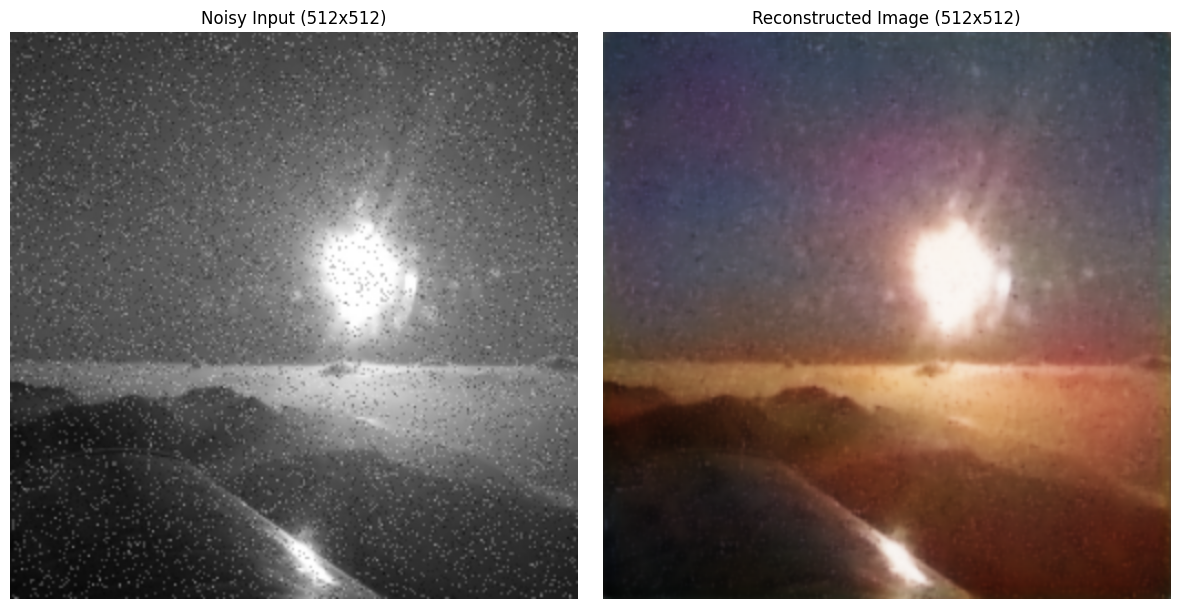

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Function to preprocess a single image
def preprocess_single_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)  # Resize to the model's input size
    img = img / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to resize an image for consistent visualization
def resize_for_display(image, target_size=(512, 512)):
    image = (image * 255).astype(np.uint8)  # Convert to uint8 for display
    return cv2.resize(image, target_size)  # Resize to target resolution

# Path to the noisy test image
test_image_path = r"C:\Users\nandh\Desktop\project files\SALT AND PEPPER\Noisy_folder\noisy_2423327630_53ffee85a8_c.jpg"
# Preprocess the noisy image
test_image = preprocess_single_image(test_image_path)

# Pass the image through the model
reconstructed_image = model.predict(test_image)

# Postprocess the reconstructed image
reconstructed_image = np.clip(reconstructed_image[0], 0, 1)  # Remove batch dimension and clip values

# Resize both images for display
noisy_image_display = resize_for_display(test_image[0], target_size=(512, 512))
reconstructed_image_display = resize_for_display(reconstructed_image, target_size=(512, 512))

# Visualize the original noisy image and reconstructed image
plt.figure(figsize=(12, 6))

# Noisy input
plt.subplot(1, 2, 1)
plt.imshow(noisy_image_display)
plt.title("Noisy Input (512x512)")
plt.axis('off')

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_display)
plt.title("Reconstructed Image (512x512)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Save the entire model
model.save("a_deeper_unet_model.keras")
print("Model saved successfully!")


Model saved successfully!
